In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
layout = """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%   %. %.%.%       %     %.%.%4%
% % %%       %%  %   %%%   %.%2%
% % %. % %%%    %%%% .%..% % % %
% % %% % ..% %   %   %%%%% % % %
% %    %%%%% %%%   %%%.% o % % %
% %% % ..%.  %.%%%       %   % %
% %. %%.%%%%        %.%%%%  %% %
% %%  %%%%.%        %%%%.%% .% %
% %   %       %%%.%  .%.. % %% %
% % % o %.%%%   %%% %%%%%    % %
% % % %%%%%   %   % %.. % %% % %
% % % %..%. %%%%    %%% % .% % %
%1%.%   %%%   %  %%       %% % %
%3%.%.%     %       %.%.% .%   %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

In [ ]:
def parse_layout(layout):
  """idea: not model the fixed walls?
     - not model agent locations (or 1 for enemies and -1 for allies?)
  """
  lines = layout.split("\n")
  H, W = len(lines) - 2, len(lines[0]) - 2

  C = 4
  t = np.zeros((H, W, C), dtype=np.float32)

  for i, line in enumerate(lines[1:-1]):
      for j, char in enumerate(line[1:-1]):
          if char == '%':
              t[i,j,0] = 1  # wall
          #elif char == '.':
              #t[i,j,1] = 1  # food

          #elif char == 'o':
              #t[i,j,2] = 1  # power pellet
          elif char in '1234':
              pass
  return t

In [ ]:
class AutoEncoder(nn.Module):
  """ Autoencoder of pacman layouts w/ fully connected layers
  """
  def __init__(self, H=16, W=32, C=4, hidden_size=128):
    super().__init__()

    self.H = H
    self.W = W
    self.C = C
    self.input_size = H*W*C
    self.hidden_size = 128

    self.encoder = nn.Sequential(
        nn.Linear(self.input_size, 512),
        nn.ReLU(),
        nn.Linear(512, self.hidden_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(self.hidden_size, 512),
        nn.ReLU(),
        nn.Linear(512, self.input_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
def generate_random_sample(H=16, W=32, C=4, pw=0.4, pf=0.1, pp=0.005, pa=0.01):
  sample = np.zeros((H, W, C))
  # the first line contains all walls
  sample[0,:,0] = 1
  for i in range(1,H):
    # first and last are walls
    sample[i,0,0] = 1
    sample[i,-1,0] = 1
    for j in range(1,W-1):
      # the cell can either be a wall, an agent, a pellet, or a power, or nothing
      pvoid = 1 - (pw+pf+pp+pa)
      choice = np.random.choice([-1,0,1,2,3], p=[pvoid, pw, pf, pp, pa])

      if choice == -1:
        continue
      else:
        sample[i,j,choice] = 1

  # the last line contains all walls
  sample[-1,:,0] = 1

  return sample


In [ ]:
class LayoutDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x = self.data[idx]
    x = torch.tensor(x, dtype=torch.float32)
    return x

In [ ]:
N = 10000

layouts = [generate_random_sample() for _ in range(N)]
loader = DataLoader(LayoutDataset(layouts), batch_size=32, shuffle=True)

In [ ]:
def train(model, loader, loss_function, optimizer, epochs=1, batch_size=32, H=16, W=32, C=4):
  losses = []
  for epoch in range(epochs):
    for batch in loader:
      x = batch.view((-1, H*W*C))

      output = model(x)
      loss = loss_function(output, x)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

  return losses

Epoch 1/5, Loss: 0.072141
Epoch 2/5, Loss: 0.067002
Epoch 3/5, Loss: 0.063307
Epoch 4/5, Loss: 0.059728
Epoch 5/5, Loss: 0.058878


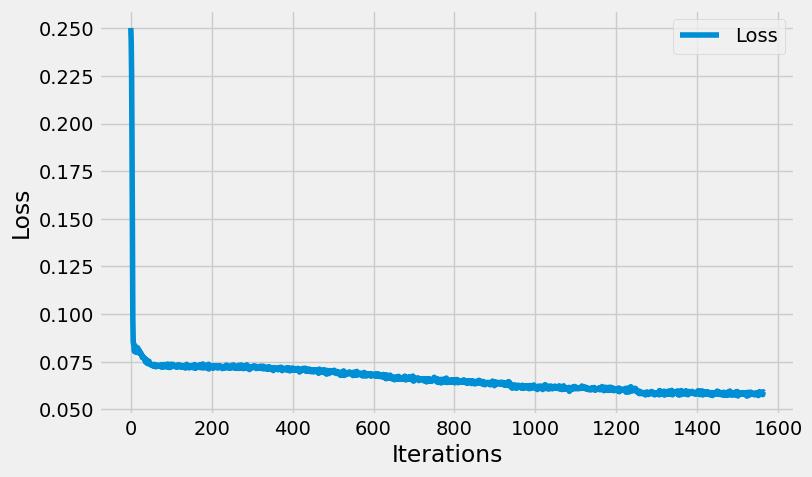

In [ ]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

losses = train(model, loader, loss_function, optimizer, epochs=5)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# copy the best agent movements? baseline classification model (4 different actions possible), use the logits

In [ ]:
sample = torch.tensor(generate_random_sample(), dtype=torch.float32).view((-1, 2048))
print(sample.shape)
recreation = model(sample)

print(np.max(sample.detach().numpy() - recreation.detach().numpy(), axis=1))


torch.Size([1, 2048])
[0.9992157]


In [ ]:
model = torch.load("model", weights_only=False)

In [ ]:
import json

with open("games.json", "r") as f:
    games = json.load(f)

encoder = model.encoder
action_to_label = {'North': 0, 'South': 1, 'West': 2, 'East': 3, 'Stop': 4}
inputs = []
outputs = []

for game in games:
  initial_layout = parse_layout(game['layout'])
  for data, action in zip(game["data"], game["agent_actions"]):
    layout = initial_layout.copy()
    # Add the food to the layout
    for food in data["food_positions"]:
      y = food[0] - 1
      x = food[1] - 1
      layout[x,y,1] = 1

    for agent_id, position in data["enemy_positions"].items():
      y = position[0] - 1
      x = position[1] - 1
      layout[x,y,3] = 1

    layout = torch.tensor(layout.ravel()).view((1, -1))
    layout = encoder(layout).squeeze()

    features = torch.tensor([
      data['score'],
      data['num_carrying'],
      data['scared_timer'],
      data['is_pacman']
    ], dtype=torch.float32)

    input = torch.cat([layout, features], dim=0)

    inputs.append(input)
    outputs.append(action_to_label[action])



In [ ]:
print(len(inputs))

9871


In [ ]:
class ActionsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [ ]:
classification_loader = DataLoader(ActionsDataset(inputs, outputs), batch_size=32, shuffle=True)

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
torch.save(classifier.state_dict(), "classifier.pth")

In [ ]:
class ActionClassifier(nn.Module):
    def __init__(self, input_dim=132, num_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

/tmp/ipython-input-3122976730.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx], dtype=torch.float32)


Epoch 1/20, Loss: 1.3559
Epoch 2/20, Loss: 1.3033
Epoch 3/20, Loss: 1.2847
Epoch 4/20, Loss: 1.2753
Epoch 5/20, Loss: 1.2696
Epoch 6/20, Loss: 1.2621
Epoch 7/20, Loss: 1.2570
Epoch 8/20, Loss: 1.2535
Epoch 9/20, Loss: 1.2466
Epoch 10/20, Loss: 1.2414
Epoch 11/20, Loss: 1.2358
Epoch 12/20, Loss: 1.2302
Epoch 13/20, Loss: 1.2281
Epoch 14/20, Loss: 1.2231
Epoch 15/20, Loss: 1.2179
Epoch 16/20, Loss: 1.2136
Epoch 17/20, Loss: 1.2112
Epoch 18/20, Loss: 1.2117
Epoch 19/20, Loss: 1.2058
Epoch 20/20, Loss: 1.2034


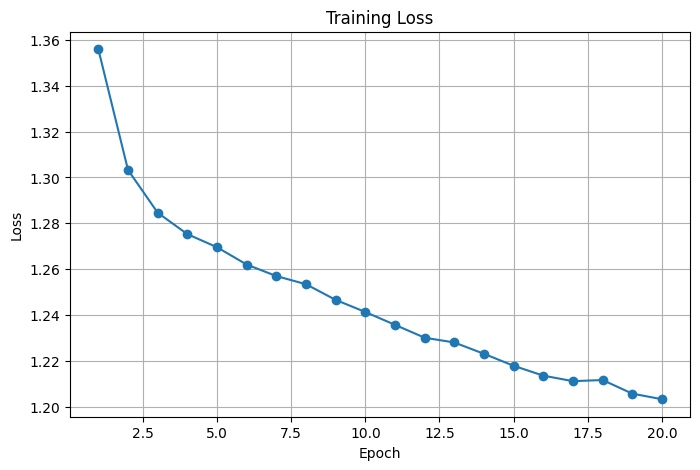

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = ActionClassifier(input_dim=132, num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    classifier.train()  # set model to training mode
    running_loss = 0.0

    for x_batch, y_batch in classification_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()       # clear previous gradients
        outputs = classifier(x_batch)    # forward pass
        loss = criterion(outputs, y_batch)  # compute loss
        loss.backward()             # backward pass
        optimizer.step()            # update weights

        running_loss += loss.item() * x_batch.size(0)

    epoch_loss = running_loss / len(classification_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    loss_history.append(epoch_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = torch.stack([t.detach() for t in inputs]).numpy()
labels = np.array(outputs)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200, max_depth= 10,random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4389873417721519


In [ ]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',  # multi-class classification
    num_class=5,                # number of classes
    random_state=42
)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.42683544303797466


In [ ]:
from collections import Counter

class_counts = Counter(outputs)
print("Class counts:", class_counts)

total = len(outputs)
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples, {count/total*100:.2f}%")

Class counts: Counter({0: 2852, 1: 2843, 3: 2130, 2: 2030, 4: 16})
Class 1: 2843 samples, 28.80%
Class 2: 2030 samples, 20.57%
Class 0: 2852 samples, 28.89%
Class 3: 2130 samples, 21.58%
Class 4: 16 samples, 0.16%
